# Quantum Disambiguatation

In [1]:
from discopy import Ty, Word
from words import sub_nouns as nouns
from words import sub_sentences as sentences

s, n = Ty('s'), Ty('n')

dataset = []
nouns, verbs = set(), set()
for sentence in sentences:
    _s = sentence.split(" ")
    dataset.append([_s[0],_s[1],int(_s[2][1])])
    verbs.add(_s[0])
    nouns.add(_s[1])


ambiguous_verbs = ["file"] #, "dribble", "tap", "charge"]


# nouns
noun_voc = {noun: Word(noun, n) for noun in nouns}
unamb_verb_voc = {verb: Word(verb, s @ n.l) for verb in verbs if verb not in ambiguous_verbs}
amb_verb_voc = {amb: Word(amb, s @ n.l) for amb in ambiguous_verbs}

In [2]:
print(unamb_verb_voc)
print(amb_verb_voc)

{'smooth': Word('smooth', Ty('s', Ob('n', z=-1))), 'register': Word('register', Ty('s', Ob('n', z=-1)))}
{'file': Word('file', Ty('s', Ob('n', z=-1)))}


## Prepare and parse dataset

In [3]:
from time import time
from discopy import Diagram, Id, Cup
from discopy.grammar import brute_force

grammar = Id(s) @ Cup(n.l, n)
sentences, plausability, parsing = list(), list(), dict()

start = time()
for entry in dataset:
    sentence = ' '.join(entry[0:2]) + '.'
    sentences.append(sentence)
    plausability.append(entry[2])

    verb = unamb_verb_voc.get(entry[0], False)
    if not verb:
        verb = amb_verb_voc[entry[0]]
    obj = noun_voc[entry[1]]
    diagram = verb @ obj >> grammar

    parsing.update({sentence: diagram})


register tooth.  plausability:  0


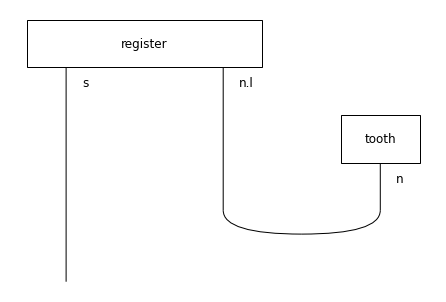

In [4]:
# display a random sentence
i = 10
print(sentences[i]," plausability: ", plausability[i])
parsing[sentences[i]].draw(draw_type_labels=True)

In [5]:
from discopy.quantum import Ket, H, Rx, Ry, Rz, CX, sqrt, X, Circuit
from random import uniform
from math import pi


# Ansätze for 1-qubit states
def un_amb_verb_ansatz(p):
    return Ket(p[0])

def amb_verb_ansatz(p):
    return Ket(0) >>  \
        Rx(p[0])

def noun_ansatz(p):
    return Ket(0) >> \
        Rx(p[0]) >> \
        Rz(p[1])


n_qubits_ansatz = 1
n_noun_params = 2
n_amb_params = 1

print(amb_verb_ansatz([uniform(0,1) for i in range(n_amb_params)]).eval())

Tensor(dom=Dim(1), cod=Dim(2), array=[0.25221352+0.j    , 0.    -0.96767161j])


In [6]:

# prepare intitial params
binaries = [list(bin(i)[2:]) for i, verb in enumerate(unamb_verb_voc.keys())]
int_binaries = [[0]*(n_qubits_ansatz - len(bi)) + [int(b) for b in bi] for bi in binaries]

n_nouns = len(nouns)
n_amb_verbs = len(ambiguous_verbs)
n_unamb_verbs = len(unamb_verb_voc)

params_unamb_verbs = {verb: int_binaries[i] for i, verb in enumerate(unamb_verb_voc.keys())}
params_nouns = {noun: [uniform(0, 1) for i in range(n_noun_params)] for noun in noun_voc}
params_amb_verbs = {verb: [uniform(0, 1) for i in range(n_amb_params)] for verb in amb_verb_voc}

In [7]:
params_unamb_verbs

{'smooth': [0], 'register': [1]}

Circuit for 'register account.':


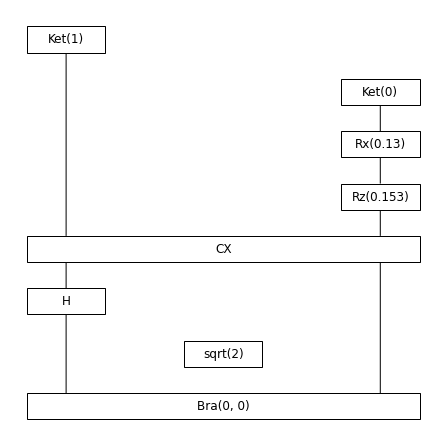

Tensor(dom=Dim(1), cod=Dim(1), array=[0.18312504-0.35134966j])

In [8]:
from discopy import CircuitFunctor, qubit


def F(params_nouns, params_unamb_verbs, params_amb_verbs):
    ar1 = {noun_voc[noun]:noun_ansatz(params_nouns[noun]) for noun in noun_voc}
    ar2 = {unamb_verb_voc[verb]:un_amb_verb_ansatz(params_unamb_verbs[verb]) for verb in unamb_verb_voc}
    ar3 = {amb_verb_voc[verb]:amb_verb_ansatz(params_amb_verbs[verb]) for verb in amb_verb_voc}
    ar = {**ar1, **ar2, **ar3}

    return CircuitFunctor(
        ob = {s: qubit ** 0, n: qubit ** n_qubits_ansatz},
        ar = ar)

print("Circuit for 'register account.':")
circuit = F(params_nouns, params_unamb_verbs, params_amb_verbs)(parsing['register account.'])
circuit.draw(figsize=(6, 6), aspect='auto', draw_type_labels=False)
circuit.eval()

In [9]:
from pytket.extensions.qiskit import AerBackend, tk_to_qiskit
backend = AerBackend()
result = circuit.eval(backend)

<tket::Circuit, qubits=2, gates=7>:
X q[0];
Rx(0.259349) q[1];
Rz(0.305875) q[1];
CX q[0], q[1];
Measure q[1] --> c[1];
H q[0];
Measure q[0] --> c[0];

post selection:
{0: 0, 1: 0}

scalar:
1.4142135623730951

qiskit circuit:


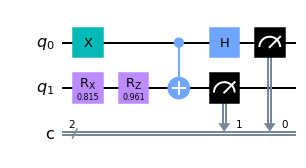

In [10]:
tk_circ = circuit.to_tk()
print("{}:\n{}\n".format(tk_circ, '\n'.join(map(str, tk_circ))))
print("post selection:\n{}\n".format(tk_circ.post_selection))
print("scalar:\n{}\n".format(tk_circ.scalar))
print("qiskit circuit:")
tk_to_qiskit(tk_circ).draw(output="mpl")

In [11]:
import numpy as np

# define evaluation function
def evaluate(params_nouns, params_unamb_verbs, params_amb_verbs, sentences, backend=AerBackend(), n_shots=2**10, seed=0):
    circuits = [F(params_nouns, params_unamb_verbs, params_amb_verbs)(parsing[sent]) for sent in sentences]
    results = [Circuit.eval(
                circuit,
                backend=backend,
                n_shots=n_shots,
                seed=seed,
                compilation=backend.default_compilation_pass(2)) for circuit in circuits]
    tensors = [np.abs(result.array)[0] for result in results]
    return tensors

In [12]:
def reshape_data(params_np):
    ''' Converts numpy array of parameters back to dictionary
    '''
    params_nouns_np = params_np[:n_nouns*n_noun_params].reshape((n_nouns,n_noun_params))
    params_amb_verbs_np = params_np[n_nouns*n_noun_params:].reshape((n_amb_verbs,n_amb_params))

    params_nouns = {word: params_nouns_np[i].tolist() for i, word in enumerate(nouns)}
    params_amb_verbs = {word: params_amb_verbs_np[i].tolist() for i, word in enumerate(amb_verb_voc)}

    return params_nouns, params_amb_verbs

def loss(params_np, sentences=sentences, plausability=plausability):

    # convert np to dict
    params_nouns, params_amb_verbs = reshape_data(params_np)

    return np.mean(np.array([
        (plausability[i] - scalar) ** 2
        for i, scalar in enumerate(evaluate(params_nouns, params_unamb_verbs, params_amb_verbs, sentences))]))

## Fit model with genetic algorithm

 The best solution found:
 [0.54703077 0.93525277 0.94609256 ... 0.44741549 0.70418462 0.32844744]

 Objective function:
 0.073287116156684


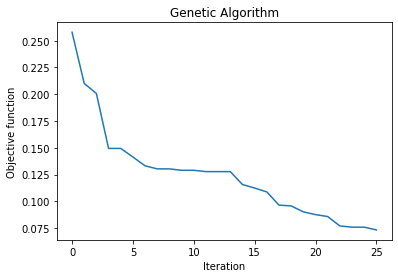

In [13]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

algorithm_param = {
    'max_num_iteration': 25,\
    'population_size':5,\
    'mutation_probability':0.1,\
    'elit_ratio': 0.01,\
    'crossover_probability': 0.5,\
    'parents_portion': 0.3,\
    'crossover_type':'uniform',\
    'max_iteration_without_improv':None
}

dimension = n_noun_params*n_nouns + n_amb_params*n_amb_verbs
varbound=np.array([[0,1]]*dimension)

model=ga(function=loss,dimension=dimension, variable_type='real',variable_boundaries=varbound, algorithm_parameters=algorithm_param, function_timeout=100)

model.run()

### Display results after GA

In [14]:
best_params_nouns, best_params_amb_verbs = reshape_data(model.best_variable)
print(best_params_nouns)
print("\n")
print(best_params_amb_verbs)

{'declaration': [0.5470307710157393, 0.9352527699612128], 'shank': [0.9460925559063206, 0.09341257973238881], 'tooth': [0.8157985295485471, 0.08191832074901118], 'lawsuit': [0.5911071485750954, 0.06450676180696047], 'charge_n': [0.7049842617000602, 0.8713073883352365], 'steel': [0.9061931697487693, 0.18918437779227226], 'nail': [0.020056127192070505, 0.22874835225443246], 'account': [0.3281898178326468, 0.5590172957317825], 'application': [0.44741549082553034, 0.7041846154785845]}


{'file': [0.32844743880886385]}


In [15]:
# Wave function of "file"
print(amb_verb_ansatz(best_params_amb_verbs['file']).eval())

Tensor(dom=Dim(1), cod=Dim(2), array=[0.51323363+0.j    , 0.    -0.85824894j])


In [16]:
def loss2(params_np, sentences=sentences, plausability=plausability):

    # convert back to dict
    params_nouns, params_amb_verbs = reshape_data(params_np)

    return  {sentences[i]:(plausability[i], round(scalar,4))
        for i, scalar in enumerate(evaluate(params_nouns, params_unamb_verbs, params_amb_verbs, sentences))}

In [17]:
# Output computed values vs. true values
loss2(model.best_variable)

{'file account.': (1, 0.9609),
 'register account.': (1, 0.7168),
 'smooth account.': (0, 0.2871),
 'file nail.': (1, 0.2988),
 'register nail.': (0, 0.002),
 'smooth nail.': (1, 0.9688),
 'file charge_n.': (1, 0.8301),
 'register charge_n.': (1, 0.6367),
 'smooth charge_n.': (0, 0.3613),
 'file tooth.': (1, 0.7578),
 'register tooth.': (0, 0.3203),
 'smooth tooth.': (1, 0.709),
 'file application.': (1, 0.8223),
 'register application.': (1, 0.9648),
 'smooth application.': (0, 0.0273),
 'file steel.': (1, 0.3672),
 'register steel.': (0, 0.0957),
 'smooth steel.': (1, 0.8691),
 'file lawsuit.': (1, 0.9746),
 'register lawsuit.': (1, 0.9277),
 'smooth lawsuit.': (0, 0.0703),
 'file shank.': (1, 0.3926),
 'register shank.': (0, 0.0176),
 'smooth shank.': (1, 0.9688),
 'file declaration.': (1, 0.8574),
 'register declaration.': (1, 1.0137),
 'smooth declaration.': (0, 0.0234)}

## Finetune with noisyopt

In [18]:
import noisyopt
from time import time
i, start = 0, time()

def callback(loss):
    global i
    i += 1
    print("Epoch {} ({:.0f} seconds since start): {}".format(i, time() - start, loss))

result = noisyopt.minimizeSPSA(
    loss, model.best_variable, paired=False, callback=callback, niter=200, a=0.2, c=0.1)

print("Best loss: ", result.fun)

Start loss:  inf
Epoch 1 (5 seconds since start): 0.08209934941044558
Epoch 2 (9 seconds since start): 0.05937152438693573
Epoch 3 (14 seconds since start): 0.059968453866464086
Epoch 4 (19 seconds since start): 0.05593956841362845
Epoch 5 (23 seconds since start): 0.0545398570873119
Epoch 6 (28 seconds since start): 0.057069425229673
Epoch 7 (33 seconds since start): 0.05131177549008967
Epoch 8 (37 seconds since start): 0.054593121563946724
Epoch 9 (42 seconds since start): 0.05204391479492184
Epoch 10 (47 seconds since start): 0.04867949309172451
Epoch 11 (52 seconds since start): 0.04879294501410587
Epoch 12 (57 seconds since start): 0.046240206117983185
Epoch 13 (62 seconds since start): 0.04468324449327254
Epoch 14 (66 seconds since start): 0.04901772958260992
Epoch 15 (71 seconds since start): 0.04867370040328411
Epoch 16 (76 seconds since start): 0.044357017234519645
Epoch 17 (81 seconds since start): 0.04258007473415795
Epoch 18 (86 seconds since start): 0.04576944421838828
Epo

In [19]:
results = loss2(result.x)

In [20]:
best_loss = result.fun
print(best_loss)

0.02576474790219904


## Save results


In [21]:
import datetime, os
folder = './experiments/1_qb_model_' + datetime.datetime.now().strftime("%Y-%m-%d")+ "_best_loss_" + str(round(best_loss,4))
os.makedirs(folder)

In [22]:
import json

params_nouns, params_amb_verbs = reshape_data(result.x)

fiel_path_params_amb_verbs = os.path.join(folder,'parameters_amb_verbs.json')
fiel_path_params_unamb_verbs = os.path.join(folder,'parameters_unamb_verbs.json')
fiel_path_params_nouns = os.path.join(folder,'params_nouns.json')

fiel_path_results = os.path.join(folder,'results.json')

with open(fiel_path_params_amb_verbs, 'w') as fp:
    json.dump(params_amb_verbs, fp)

with open(fiel_path_params_unamb_verbs, 'w') as fp:
    json.dump(params_unamb_verbs, fp)

with open(fiel_path_params_nouns, 'w') as fp:
    json.dump(params_nouns, fp)

with open(fiel_path_results, 'w') as fp:
    json.dump(results, fp)

In [23]:
# save the optimizer evolution steps for animation
evolution_genetic = dict()
for i, sol in enumerate(model.best_variable_report):
    key = "evo" + str(i+1)
    params_nouns_ev, params_amb_verbs_ev = reshape_data(sol)
    evolution_genetic[key] = {"nouns": params_nouns_ev, "amb_verbs": params_amb_verbs_ev}


fiel_path_evolution = os.path.join(folder,'params_evolution_genetic.json')
with open(fiel_path_evolution, 'w') as fp:
    json.dump(evolution_genetic, fp)

In [24]:
# save the optimizer evolution steps for animation
evolution_noisy = dict()
for sol in result.evo:
    params_nouns_ev, params_amb_verbs_ev = reshape_data(result.evo[sol])
    evolution_noisy[sol] = {"nouns": params_nouns_ev, "amb_verbs": params_amb_verbs_ev}

evolution_noisy["loss"] = result.loss_arr

fiel_path_evolution = os.path.join(folder,'params_evolution_noisy.json')
with open(fiel_path_evolution, 'w') as fp:
    json.dump(evolution_noisy, fp)